In [ ]:
target_texts = [
    # Educational / Academic
    "help me with this schoool prgft explain heat transfer",
    "i want to understnad photosythisis",
    "what is syntex in python",
    "plese explane the differnce between mitosis and miosis",
    "how does gravvity affect motion in space",
    "tell me abot the french revoluton",
    "wht is the capital of argintina",
    "i need sumary of romeo and juliet act 3",
    "can you help me with a reserch idea in linguistics",
    "how to write a paragraf about climate chnge",

    # Tech related
    "whats the diffrence between js and jva",
    "how to fix modl not found error in pytorch",
    "plz help me undrstand api request and respons",
    "whats the use of pandas libary in python",
    "how can i conect mysql databse to flask app",
    "shud i use random forst or linear regresion for this data",
    "why my cod is not printng the output",

    # Daily conversational
    "hey can u recomend a movi like interstller",
    "whts the wether in delhi today",
    "cn you remind me to call my mom tomorow",
    "how do i cook pastaa without sauce",
    "whats the best gift for a frend birthday",
    "i lost my walet what shud i do",
    "send me the adress of neerest atm",
    "is vaccation in october a good idea",
]

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import brown
from nltk import FreqDist
from textblob import Word
from nltk.corpus import stopwords
from nltk import word_tokenize
import numpy as np
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")

import nltk.corpus.reader.framenet as framenet
from nltk.corpus import framenet as fn

nltk.download('brown')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from collections import Counter
from nltk.corpus import brown
import nltk

nltk.download('punkt_tab')

def tokenize(text):
    return [t.lower() for t in nltk.word_tokenize(text) if t.isalpha()]

target_tokens = []
for s in target_texts:
    target_tokens.extend(tokenize(s))

target_counts = Counter(target_tokens)

ref_tokens = [w.lower() for w in brown.words() if w.isalpha()]
ref_counts = Counter(ref_tokens)

print(f"Target tokens: {len(target_tokens)}   Unique: {len(target_counts)}")
print(f"Reference (Brown) tokens: {len(ref_tokens)}   Unique: {len(ref_counts)}")
print()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Target tokens: 192   Unique: 126
Reference (Brown) tokens: 981716   Unique: 40234



In [ ]:
# 4. Keyness (Chi-square)

def chi_square_for_word(a, N1, c, N2):
    b, d = N1 - a, N2 - c
    table = np.array([[a, b], [c, d]])
    try:
        chi2, p, _, _ = chi2_contingency(table, correction=False)
    except Exception:
        chi2, p = 0.0, 1.0
    return float(chi2), float(p)

N1, N2 = sum(target_counts.values()), len(ref_tokens)
rows = []
for word, a in target_counts.items():
    c = ref_counts.get(word, 0)
    chi2_val, p_val = chi_square_for_word(a, N1, c, N2)
    rows.append({
        'word': word,
        'freq_in_target': a,
        'freq_in_brown': c,
        'chi2': round(chi2_val, 4),
        'p_value': p_val
    })

chi_df = pd.DataFrame(rows).sort_values('chi2', ascending=False).reset_index(drop=True)


In [ ]:
from textblob import Word
from difflib import get_close_matches

# 5. Misspelling Detection

def suggest_correction(word):
    if word in ref_counts: # If the word is in our reference corpus, it's likely correct
        return None

    # Use TextBlob for correction
    corrected_word = str(Word(word).correct())

    if corrected_word and corrected_word != word: # If textblob found a correction
        return corrected_word

    # Fallback to get_close_matches if textblob doesn't provide a good correction
    candidates = get_close_matches(word, list(ref_counts.keys()), n=2, cutoff=0.75)
    return candidates[0] if candidates else None

chi_df['suggested_correction'] = chi_df['word'].apply(suggest_correction)

In [ ]:
HAVE_FRAMENET = True

# 6. Frame Features

def get_frame_features(word):
    if HAVE_FRAMENET and fn:
        try:
            lus = fn.lus(word)
            if lus:
                frames = list({lu.frame.name for lu in lus})
                return 1, len(frames), frames
            return 0, 0, []
        except Exception:
            return 0, 0, []
    else:
        fallback_frame_keywords = {
            'heat': ['Temperature_change'],
            'transfer': ['Transfer'],
            'motion': ['Motion'],
            'gravity': ['Gravity'],
            'electricity': ['Electricity'],
            'syntax': ['Syntax'],
            'python': ['Programming_language'],
            'weather': ['Weather'],
            'movie': ['Art_form']
        }
        frames = fallback_frame_keywords.get(word, [])
        return (1, len(frames), frames) if frames else (0, 0, [])

chi_df[['has_frame', 'frame_count', 'frames']] = chi_df['word'].apply(
    lambda w: pd.Series(get_frame_features(w))
)

In [ ]:
#relevance calculation
chi_df['chi2_log'] = chi_df['chi2'].apply(lambda x: np.log1p(x))
FRAME_BOOST = 1.5
KEY_FREQ_WEIGHT = 0.2
chi_df['relevance'] = (
    chi_df['chi2_log']
    + chi_df['frame_count'] * FRAME_BOOST
    + chi_df['freq_in_target'] * KEY_FREQ_WEIGHT
)

In [ ]:
#creating alert system
RELEVANCE_THRESHOLD = 1.0
HIGH_RELEVANCE_THRESHOLD = 2.5

def decide_alert(row):
    corr, rel, has_frame = row['suggested_correction'], row['relevance'], row['has_frame']
    if not corr:
        return None
    if has_frame and rel >= RELEVANCE_THRESHOLD:
        return f"🚨 Frame-critical typo: {row['word']} → {corr}"
    if rel >= HIGH_RELEVANCE_THRESHOLD:
        return f"⚠️ High-impact typo: {row['word']} → {corr}"
    return f"✅ Minor typo (autocorrectable): {row['word']} → {corr}"

chi_df['alert'] = chi_df.apply(decide_alert, axis=1)

In [ ]:
final_df = chi_df[['word', 'freq_in_target', 'freq_in_brown', 'chi2', 'p_value',
                   'suggested_correction', 'has_frame', 'frame_count', 'frames',
                   'chi2_log', 'relevance', 'alert']].sort_values('relevance', ascending=False)

print("\n=== Frame-Aware Typo Detection Table ===\n")
print(final_df.to_string(index=False))

alerts = final_df['alert'].dropna().tolist()
print("\n=== Alerts ===")
if not alerts:
    print("No alerts raised.")
else:
    for a in alerts:
        print(a)

final_df.to_csv("frame_aware_typo_results.csv", index=False)
print("\n✅ Results saved to 'frame_aware_typo_results.csv'")



=== Frame-Aware Typo Detection Table ===

         word  freq_in_target  freq_in_brown       chi2       p_value suggested_correction  has_frame  frame_count frames  chi2_log  relevance                                           alert
        whats               3              0 15339.3594  0.000000e+00                 what          0            0     []  9.638243  10.238243               ⚠️ High-impact typo: whats → what
         shud               2              0 10226.2292  0.000000e+00                 shed          0            0     []  9.232809   9.632809                ⚠️ High-impact typo: shud → shed
photosythisis               1              0  5113.1094  0.000000e+00                 None          0            0     []  8.539759   8.739759                                            None
   understnad               1              0  5113.1094  0.000000e+00           understand          0            0     []  8.539759   8.739759    ⚠️ High-impact typo: understnad → understand
  

In [ ]:
df = pd.read_csv("/content/frame_aware_typo_results.csv")
print(df)

              word  freq_in_target  freq_in_brown        chi2   p_value  \
0            whats               3              0  15339.3594  0.000000   
1             shud               2              0  10226.2292  0.000000   
2    photosythisis               1              0   5113.1094  0.000000   
3       understnad               1              0   5113.1094  0.000000   
4            plese               1              0   5113.1094  0.000000   
..             ...             ...            ...         ...       ...   
121             to               5          26158      0.0027  0.958591   
122          about               1           1815      1.1736  0.278656   
123           with               2           7289      0.2331  0.629198   
124            for               2           9489      0.0113  0.915312   
125             or               1           4206      0.0384  0.844608   

    suggested_correction  has_frame  frame_count frames  chi2_log  relevance  \
0                  

In [ ]:
final_df['alert_type'] = final_df['alert'].apply(lambda x: 'critical' if 'Frame' in str(x)
                                                 else 'high' if 'High' in str(x)
                                                 else 'minor' if 'Minor' in str(x)
                                                 else 'none')

print(final_df['alert_type'].value_counts(normalize=True))


alert_type
none    0.603175
high    0.396825
Name: proportion, dtype: float64


In [ ]:
final_df.groupby("alert_type")[["relevance", "frame_count"]].mean()

,relevance,frame_count
alert_type,,
high,8.787589,0.0
none,4.156666,0.0


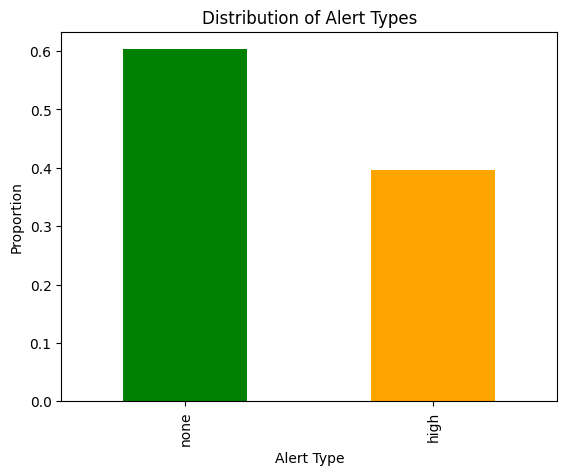

In [ ]:
import matplotlib.pyplot as plt

final_df["alert_type"].value_counts(normalize=True).plot(kind="bar", color=['green', 'orange', 'red'])
plt.title("Distribution of Alert Types")
plt.xlabel("Alert Type")
plt.ylabel("Proportion")
plt.show()

RAG

In [ ]:
academic_corpus = [
    "Photosynthesis is the process by which plants convert light energy into chemical energy.",
    "Heat transfer occurs through conduction, convection, and radiation.",
    "Mitosis and meiosis are forms of cell division.",
    "Syntax refers to the structure of sentences in a language.",
    "Gravity affects motion by exerting force on mass."
]


In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

model = SentenceTransformer("all-MiniLM-L6-v2")

corpus_embeddings = model.encode(academic_corpus)
index = faiss.IndexFlatL2(corpus_embeddings.shape[1])
index.add(corpus_embeddings)


In [ ]:
from sklearn.neighbors import NearestNeighbors

word_list = ["photosynthesis", "mitosis", "syntax", "movie", "weather"]
word_embeddings = model.encode(word_list)

knn = NearestNeighbors(n_neighbors=3).fit(word_embeddings)


In [ ]:
import nltk
from nltk.corpus import framenet as fn

def has_frame(word):
    try:
        return 1 if fn.lus(word) else 0
    except:
        return 0



In [ ]:
def decide_typo_severity(word):
    # FrameNet signal
    frame_signal = has_frame(word)

    # FAISS retrieval
    query_emb = model.encode([word])
    D, I = index.search(query_emb, k=2)
    faiss_context = [academic_corpus[i] for i in I[0]]

    # KNN neighbors
    word_vec = model.encode([word])
    _, indices = knn.kneighbors(word_vec)
    knn_neighbors = [word_list[i] for i in indices[0]]

    # Scoring
    score = 0
    score += frame_signal
    score += 1 if len(faiss_context) > 0 else 0
    score += 1 if any(w in word_list for w in knn_neighbors) else 0

    decision = "⚠️ Semantically important typo" if score >= 2 else "✅ Likely ignorable typo"

    return {
        "word": word,
        "frame_signal": frame_signal,
        "faiss_context": faiss_context,
        "knn_neighbors": knn_neighbors,
        "decision": decision
    }

In [ ]:
test_words = [
    "photosynthesis",
    "miosis",
    "syntex",
    "schoool",
    "prgft",
    "gravity"
]

for w in test_words:
    print("=" * 60)
    result = decide_typo_severity(w)

    print("Word:", result["word"])
    print("FrameNet:", result["frame_signal"])
    print("FAISS Context:")
    for c in result["faiss_context"]:
        print(" -", c)

    print("KNN Neighbors:", result["knn_neighbors"])
    print("Decision:", result["decision"])

Word: photosynthesis
FrameNet: 0
FAISS Context:
 - Photosynthesis is the process by which plants convert light energy into chemical energy.
 - Mitosis and meiosis are forms of cell division.
KNN Neighbors: ['photosynthesis', 'mitosis', 'movie']
Decision: ⚠️ Semantically important typo
Word: miosis
FrameNet: 0
FAISS Context:
 - Mitosis and meiosis are forms of cell division.
 - Photosynthesis is the process by which plants convert light energy into chemical energy.
KNN Neighbors: ['mitosis', 'photosynthesis', 'movie']
Decision: ⚠️ Semantically important typo
Word: syntex
FrameNet: 0
FAISS Context:
 - Mitosis and meiosis are forms of cell division.
 - Syntax refers to the structure of sentences in a language.
KNN Neighbors: ['mitosis', 'syntax', 'movie']
Decision: ⚠️ Semantically important typo
Word: schoool
FrameNet: 0
FAISS Context:
 - Heat transfer occurs through conduction, convection, and radiation.
 - Syntax refers to the structure of sentences in a language.
KNN Neighbors: ['movie